
# **Automatically classify consumer goods**

##***Preprocess image data to obtain a usable data set***

*Place de marché* is a company that wants to launch an e-commerce marketplace.
Manual classification of items by sellers is unreliable and limited.

As a Data Scientist within this company, I have to evaluate the feasibility of an automatic product classification system, using photos and descriptions. My work includes data preprocessing, feature extraction, reduction to 2 dimensions for visualization, and category clustering analysis.

*NB: The images and descriptions as well as all the data used here are public data available on the website of the company “Marketplace” and are not intellectual property.*

<u><strong>Summary</strong></u> :<br>
<br>
<strong>Tools</strong> <a href="https://colab.research.google.com/drive/1P2prqyt9EdVdd3LU_DeyyZ8wA7cCc198#scrollTo=ad04d6df">(here)</a><br><br>
<strong>II. Preprocess image data to obtain a usable data set</strong><br>
     -- A. Data preparation <a href="https://colab.research.google.com/drive/1P2prqyt9EdVdd3LU_DeyyZ8wA7cCc198#scrollTo=f6165234">(here)</a><br>
     -- B. Performing bag-of-images feature engineering by generating descriptors using ORB and  CNN Transfer Learning algorithms <a href="https://colab.research.google.com/drive/1P2prqyt9EdVdd3LU_DeyyZ8wA7cCc198#scrollTo=3ce16c9a&line=1&uniqifier=1">(here)</a><br>
     ---- <i>☛ Storing ORB Features in a Separate Structure<br>
     ---- ☛ Applying CNN Feature Extraction to All Images</i>   
     -- C. Visualization and Analysis of Image Features with T-SNE <a href="https://colab.research.google.com/drive/1P2prqyt9EdVdd3LU_DeyyZ8wA7cCc198#scrollTo=1jVzCEz7T8HP">(here)</a><br>
     ---- <i>☛ Applying T-SNE to CNN Features<br>
     ---- ☛ Results visualization</i>  

****

### **Tools**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

from matplotlib.collections import LineCollection
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
from sklearn import cluster, metrics
from sklearn.metrics import silhouette_score

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input,
              outputs=base_model.get_layer('fc1').output)

warnings.filterwarnings('ignore')

In [ ]:
def split_column(df, column_name):
    """
    Split a DataFrame column into multiple columns using space as the separator.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the column to split.
    column_name (str): The name of the column to split.

    Returns:
    pandas.DataFrame: A DataFrame with the original column split into multiple columns.
    """
    if column_name in df.columns:
        new_cols = df[column_name].str.split(',', expand=True)
        # Rename the new columns
        new_cols.columns = [
            f"{column_name}_{i}" for i in range(new_cols.shape[1])
        ]
        # Concatenate the new columns to the original DataFrame
        df = pd.concat([df, new_cols], axis=1)
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

    return df

In [ ]:
def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found or unable to read: {image_path}")
        return None

    # Obtention des dimensions originales de l'image
    height, width = image.shape[:2]

    # Calcul de la nouvelle taille (réduite de moitié)
    new_size = (width // 2, height // 2)

    # Redimensionnement de l'image
    image = cv2.resize(image, new_size)

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    updated_lab = cv2.merge([l, a, b])
    contrast_enhanced_image = cv2.cvtColor(updated_lab, cv2.COLOR_LAB2BGR)
    gray_image = cv2.cvtColor(contrast_enhanced_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    return blurred_image


def show_processed_images_by_category(df,
                                      image_directory,
                                      num_images=3,
                                      target_size=(100, 100)):
    for category in df['category'].unique():
        category_df = df[df['category'] == category]

        images_shown = 0
        plt.figure(figsize=(15, 5))  # Ajustez la taille selon le besoin
        for _, row in category_df.iterrows():
            if images_shown < num_images:
                image_path = os.path.join(image_directory, row['image'])
                processed_image = process_image(image_path)

                if processed_image is not None:
                    ax = plt.subplot(1, num_images, images_shown + 1)
                    ax.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
                    ax.set_title(f"{category} - {row['image']}")
                    ax.axis('off')

                    images_shown += 1

        if images_shown > 0:
            plt.show()

In [ ]:
def extract_orb_features(image_path):
    """Extract ORB features from a preprocessed image.

    Args:
    image_path (str): Path to the image file.

    Returns:
    tuple: A tuple containing keypoints and descriptors, or (None, None) if the image cannot be processed.
    """
    # Process the image first
    processed_image = process_image(image_path)
    if processed_image is None:
        print(f"Unable to process image at {image_path}")
        return None, None

    # Convert to grayscale if not already
    gray = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY) if len(
        processed_image.shape) == 3 else processed_image

    # Initialize ORB feature extractor
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)

    return keypoints, descriptors


def extract_cnn_features(image_path, model):
    """Extract features from an image using a CNN model.

    Args:
    image_path (str): Path to the image file.
    model (tensorflow.keras.models.Model): Pre-trained CNN model.

    Returns:
    numpy.ndarray: Extracted features, or None if the image cannot be processed.
    """
    try:
        # Load and preprocess the image
        img = keras_image.load_img(image_path, target_size=(224, 224))
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Extract features
        features = model.predict(img_array)
        return features
    except (OSError, Exception) as e:
        print(f"Error processing image {image_path}: {e}")
        return None



---



## **I. Preprocess image data to obtain a usable data set**

### **A. Dataset preparation**

In [ ]:
data = pd.read_csv(
    "/content/drive/MyDrive/flipkart_com-ecommerce_sample_1050.csv", sep=",")
data.shape

(1050, 15)

In [ ]:
# New df
data = data[["uniq_id", "product_category_tree", "image"]]
data.head()

,uniq_id,product_category_tree,image
0,55b85ea15a1536d46b7190ad6fff8ce7,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg


In [ ]:
# Removing special characters from the "product_category_tree" column
data['product_category_tree'] = data['product_category_tree'].str.replace(
    ">>", ",", regex=True)

# Call function to split column 'product_category_tree' of DataFrame 'data'
data = split_column(data, 'product_category_tree')
data['product_category_tree_0'] = data['product_category_tree_0'].astype(str)

# Remove special character
data['category'] = data['product_category_tree_0'].str.replace(
    "\['", "").str.replace("\W+", " ", regex=True).str.strip()

# Final df
data = data[["uniq_id", "category", "image"]]
data.head()

,uniq_id,category,image
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg


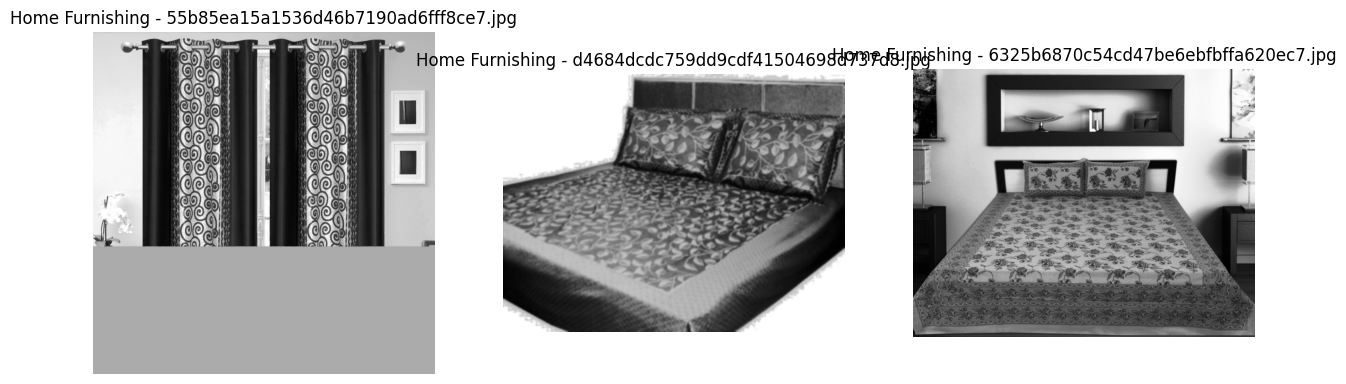

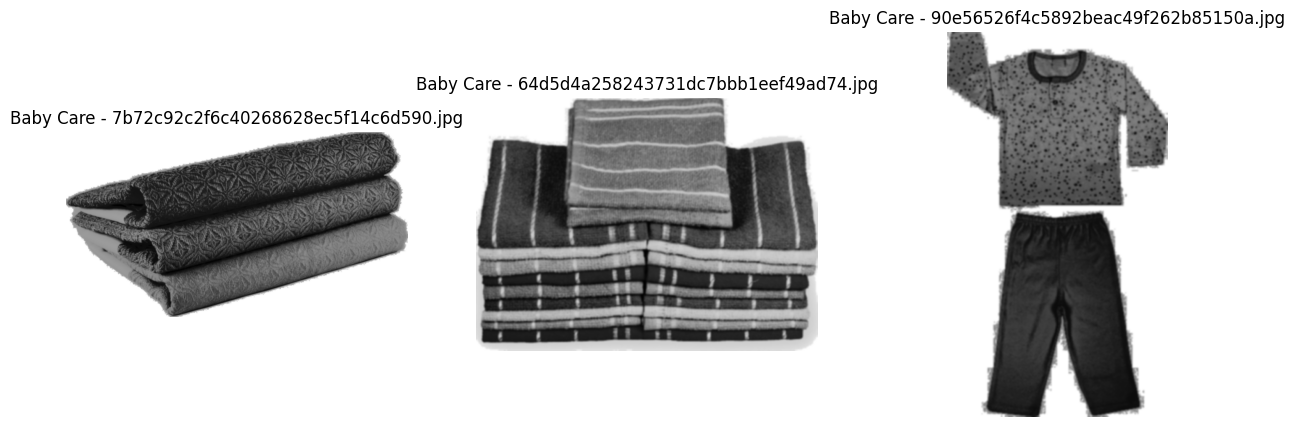

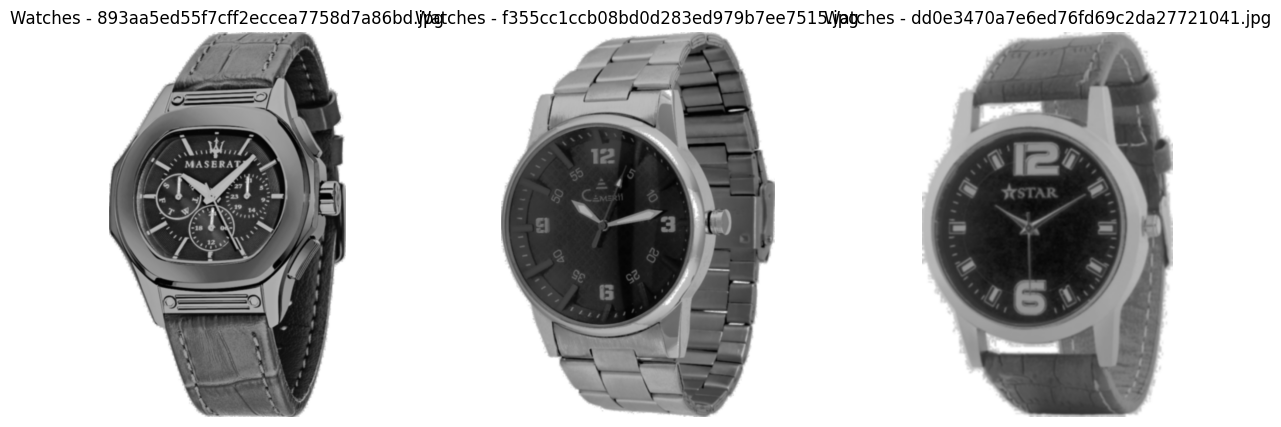

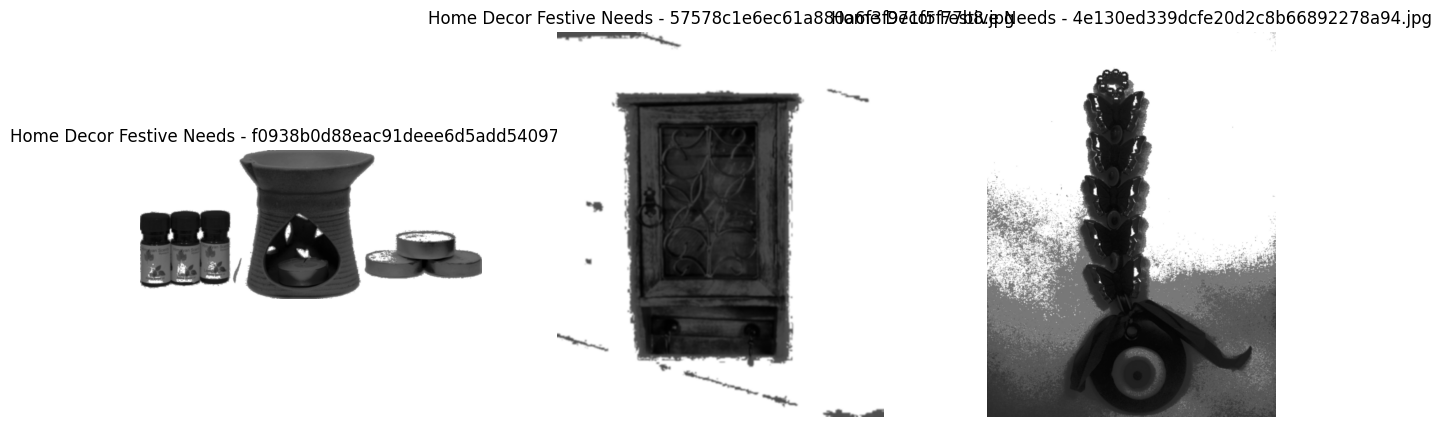

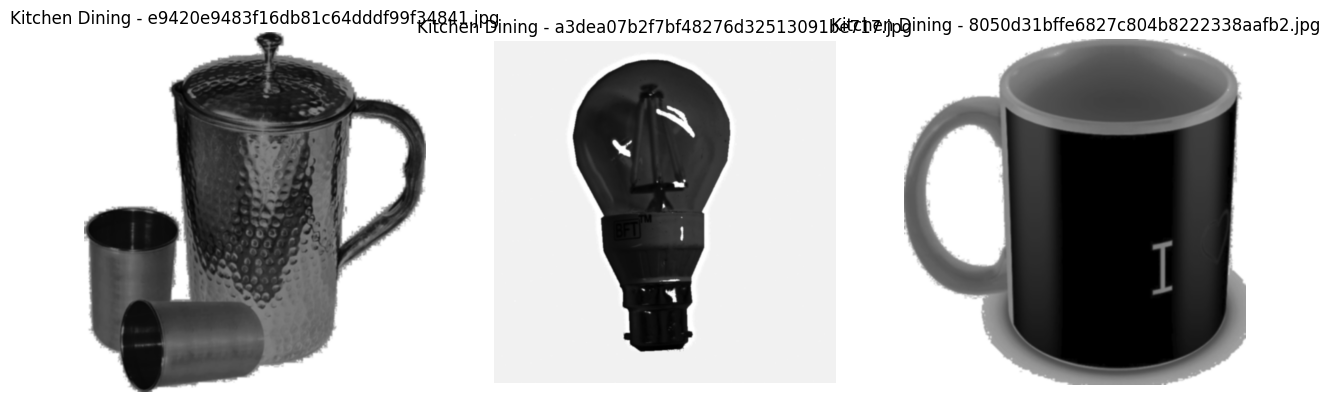

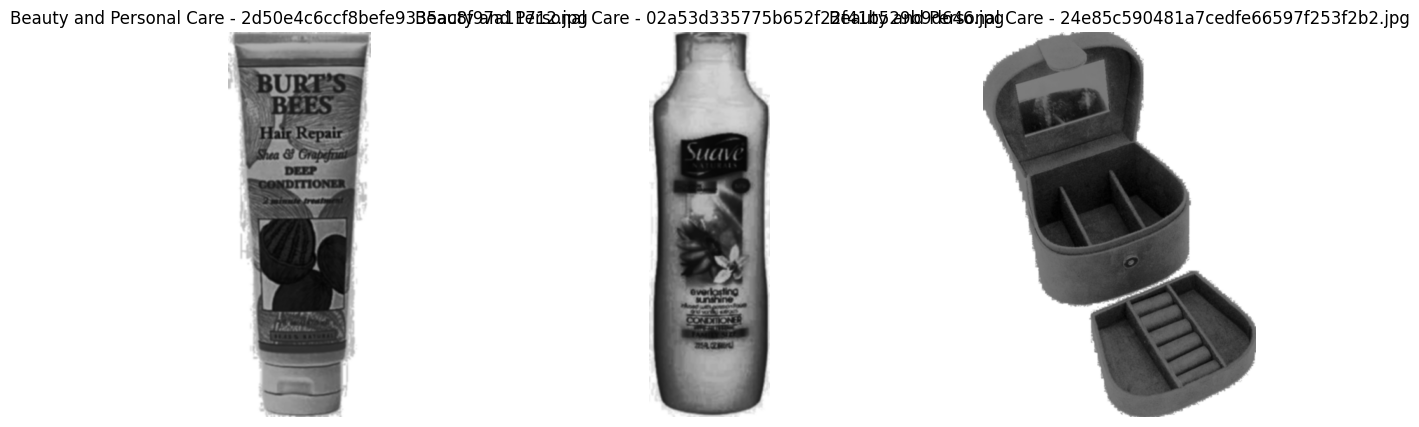

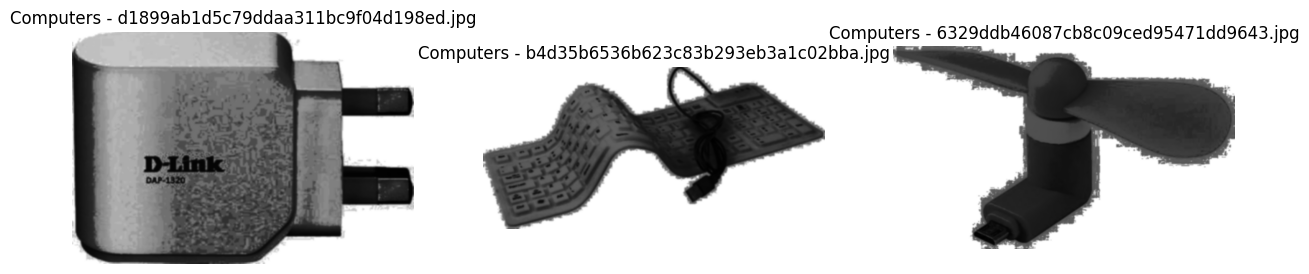

In [ ]:
# Print processed images by category
image_directory = '/content/drive/MyDrive/pix'
show_processed_images_by_category(data, image_directory)

<div class="alert-success">
→ We performed some image preprocessing operations such as image reading, contrast processing, and grayscale conversion using libraries such as OpenCV (cv2) and pandas.<br>
</div>

****

### **B. Performing bag-of-images feature engineering by generating descriptors using ORB and  CNN Transfer Learning algorithms**

This work involves developing a 'bag-of-images' approach for feature engineering. We will create a function that uses the ORB (Oriented FAST and Rotated BRIEF) algorithm to extract features from processed images. This will enhance image recognition and analysis by extracting key features.

- **Storing ORB Features in a Separate Structure**

In [ ]:
orb_features = []

for _, row in data.iterrows():
    image_path = os.path.join(image_directory, row['image'])
    keypoints, descriptors = extract_orb_features(image_path)
    orb_features.append(descriptors)  # Stocker les descripteurs

Image not found or unable to read: /content/drive/MyDrive/pix/7c4c57dda1b2e50f40b331cc8f9d233b.jpg
Unable to process image at /content/drive/MyDrive/pix/7c4c57dda1b2e50f40b331cc8f9d233b.jpg


In [ ]:
# Creation of a DataFrame from ORB features and referencing them in the Main DataFrame
df_orb_features = pd.DataFrame({'orb_features': orb_features})
data['orb_features_index'] = range(len(data))
df_orb_features['orb_features_index'] = range(len(df_orb_features))

<div class="alert-success">
→ This approach allows us to keep ORB feature data separate from the main DataFrame data, while keeping it easily accessible via a common key.<br>
</div>

- **Applying CNN Feature Extraction to All Images**

CNN models like VGG16 expect images in color and certain dimensions (e.g., 224x224 for VGG16). So we will not use the processed images here.

In [ ]:
cnn_features = []

for _, row in data.iterrows():
    image_path = os.path.join(image_directory, row['image'])
    if os.path.exists(image_path):
        features = extract_cnn_features(image_path, model)
        if features is not None:
            cnn_features.append(features.flatten())
        else:
            cnn_features.append(None)
    else:
        print(f"File not found: {image_path}")
        cnn_features.append(None)

1/1 [==============================] - 1s 896ms/step
File not found: /content/drive/MyDrive/pix/7c4c57dda1b2e50f40b331cc8f9d233b.jpg
1/1 [==============================] - 1s 1s/step


In [ ]:
# Referencing CNN features index in the Main DataFrame
data['cnn_features_index'] = range(len(data))
data.head()

,uniq_id,category,image,orb_features_index,cnn_features_index
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,0,0
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,1,1
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,2,2
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,3,3
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,4,4


<div class="alert-success">
→ We have successfully extracted ORB and CNN features from our image dataset, storing them in separate data structures for efficient management.<br>
→  These features are now ready for advanced applications such as image classification or data analysis. A common reference key ensures easy linkage between the features and the original image metadata.
</div>

****

### **C. Visualization and Analysis of Image Features with T-SNE**

Dimension reduction is necessary because image features, especially those extracted using methods like CNN, are high-dimensional and difficult to visualize or analyze directly. Reducing to 2 dimensions allows for a better visual understanding of the relationships and groupings among the data.

- **Applying T-SNE to CNN Features**

T-SNE (t-distributed Stochastic Neighbor Embedding) is a popular technique for visualizing high-dimensional data. It is particularly well-suited for complex datasets such as image features.

In [ ]:
# Check the length of an individual CNN feature
for feature in cnn_features:
    if feature is not None:
        expected_length = len(feature)
        break
print(f"Expected length of each feature is: {expected_length}")

Expected length of each feature is: 4096


In [ ]:
# Prepare the features for T-SNE
prepared_features = [
    f if f is not None and len(f) == expected_length else
    np.zeros(expected_length) for f in cnn_features
]  # Replace any None or mismatched length features with zero vectors
cnn_features_array = np.array(
    prepared_features)  # Convert the list of features to a NumPy array

# Define ranges for perplexity and learning rate to test
perplexities = [5, 30, 50, 100]
learning_rates = [10, 200, 500, 1000]

# Variables to store the best parameters and score
best_score = -1
best_params = {'perplexity': None, 'learning_rate': None}

# Test different combinations of perplexity and learning rate
for perplexity in perplexities:
    for learning_rate in learning_rates:
        tsne = TSNE(n_components=2,
                    perplexity=perplexity,
                    learning_rate=learning_rate)
        tsne_results = tsne.fit_transform(cnn_features_array)

        # Calculate the silhouette score
        labels = data["category"]
        score = silhouette_score(tsne_results, labels)
        if score > best_score:
            best_score = score
            best_params['perplexity'] = perplexity
            best_params['learning_rate'] = learning_rate

# Print the best parameters and the corresponding silhouette score
print(
    f"Best parameters: Perplexity={best_params['perplexity']}, Learning Rate={best_params['learning_rate']}"
)
print(f"Best Silhouette Score: {best_score}")

Best parameters: Perplexity=50, Learning Rate=500
Best Silhouette Score: 0.17103588581085205


<div class="alert-success">
→ `n_components=2`: for 2D visualization.<br>
→ `perplexity=30` : a key parameter for T-SNE, often chosen between 5 and 100.<br>
→ `learning_rate=200` : often set between 10 and 1000. Too high a learning rate can lead to premature convergence.

A silhouette score of 0.179 indicates a weak structure in the data clusters, suggesting that the data does not have well-defined clusters.
</div>

- **Results visualization with data real categories**

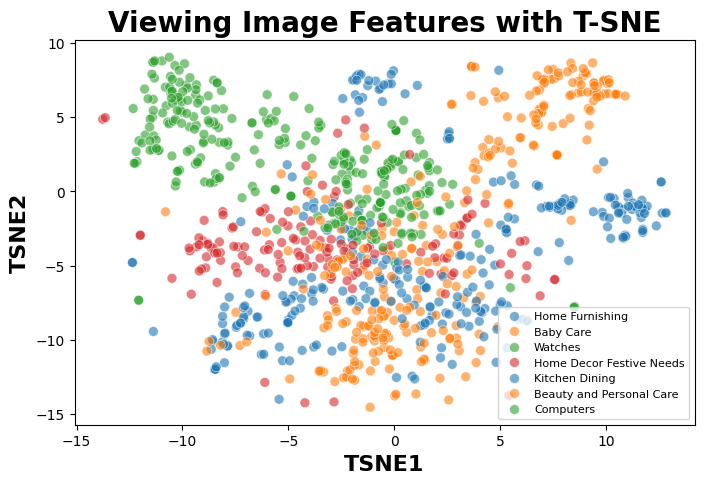

In [ ]:
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

tsne_df["class"] = data["category"]

plt.figure(figsize=(8, 5))
sns.scatterplot(x="TSNE1",
                y="TSNE2",
                hue="class",
                palette=sns.color_palette('tab10', n_colors=4),
                s=50,
                alpha=0.6,
                data=tsne_df,
                legend="brief")

plt.title('Viewing Image Features with T-SNE', fontsize=20, fontweight='bold')
plt.xlabel('TSNE1', fontsize=16, fontweight='bold')
plt.ylabel('TSNE2', fontsize=16, fontweight='bold')
plt.legend(prop={'size': 8})

plt.show()

<div class="alert-success">
→ We notice that the identical color categories overlap here, we can therefore assume that the model poorly distinguishes the category 'Baby Care' from 'Personal Care', or the category 'Home furnishing' from 'Kitchen dining'.<br>
→ We can see logic here as these categories can have similar products, particularly kitchen products in the home supplies category.
</div>

- **Creation of clusters from T-SNE and display of images according to clusters**

The graphical analysis visually shows that it is feasible to automatically separate the images into 4 categories if we group the categories 'Kitchen Dining' and 'Home furnishing', 'Personal care' and 'Baby care' as well as 'Watches' and ' Computer’.

We can demonstrate the feasibility of automatically determining the category of an image using a supervised classification model like the KMeans model.

In [ ]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(tsne_results)

KMeans(n_clusters=7, n_init=100)

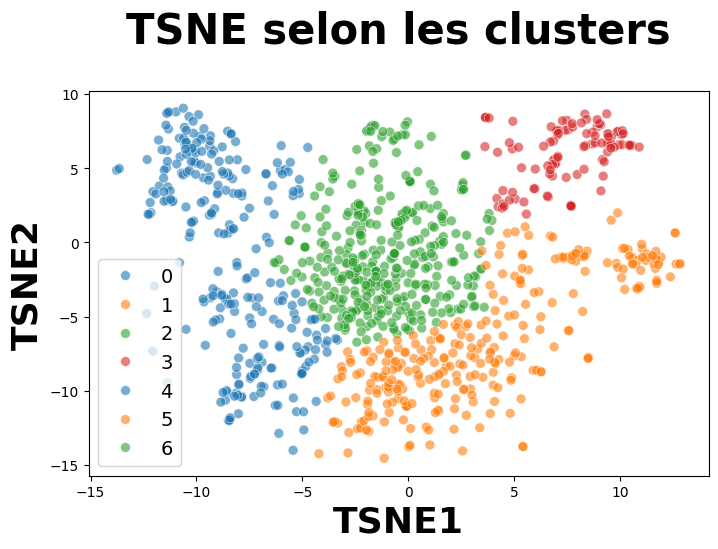

ARI :  0.3943981612090857


In [ ]:
tsne_df["cluster"] = cls.labels_

plt.figure(figsize=(8, 5))
sns.scatterplot(x="TSNE1",
                y="TSNE2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=4),
                s=50,
                alpha=0.6,
                data=tsne_df,
                legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('TSNE1', fontsize=26, fontweight='bold')
plt.ylabel('TSNE2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

<div class="alert-success">
→ An Adjusted Rand Index (ARI) of 0.39 suggests a moderate level of agreement between the clustering assignment and the true labels.<br>
→ This score indicates that while there is some meaningful correspondence between the clusters formed and the actual categories, the clustering is not perfectly aligned with the true category labels. The fact that three out of seven clusters overlap and appear almost identical suggests that the automatic clustering model is more effective at distinguishing some categories than others.<br>
→ If these overlapping categories are conceptually similar or not distinctly separable based on the features used, it might be reasonable to consider them as fewer, broader categories. In essence, the model seems to be identifying four distinct groups effectively, implying a potential for redefining or consolidating the original categories.
</div>

__________________________

Here we created a system that sorts consumer goods into categories using pictures. The system, with a score of about 0.39, shows that it can usually put products in the right groups.

**However, it is good at distinguishing certain types of products, but it struggles with others that look similar.**

**This shows we might need to improve how the system looks at pictures or think about grouping some products together in simpler categories. Future improvements could make it better at understanding different types of products.**
